In [1]:
# standard imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
# Additional imports
from sklearn import metrics
from itertools import combinations
from sklearn.linear_model import Ridge
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.cross_validation import train_test_split
import time

In [2]:
# ignore warnings on setting values ona  copy of a DF
pd.options.mode.chained_assignment = None  # default='warn'

In [2]:
def load_df(df_file):
    # function to load csv files from data folder into DataFrame
    basepath = 'data/'
    filepath = basepath + df_file
    load_df = pd.DataFrame.from_csv(filepath)
    return load_df

In [17]:
df_ny = load_df('df_ny.csv')
df_sf = load_df('df_sf.csv')
df_la = load_df('df_la.csv')
df_dc = load_df('df_dc.csv')
df_da = load_df('df_da.csv')
df_ch = load_df('df_ch.csv')

In [16]:
df_ny.head()

,Bedrooms,Capacity,Id,Price,Property_Type,Review_Count,Room_Type,Star_Rating,City,Avg_Price,Has_Star_Rating
0,1,1,12382618,38,Apartment,1,0,0.0,NY,92.918301,0
1,1,1,648047,61,Apartment,67,1,4.5,NY,92.918301,1
2,1,2,6597854,58,Apartment,6,1,5.0,NY,92.918301,1
3,1,2,8750161,56,House,36,1,5.0,NY,92.918301,1
4,0,2,11862330,130,Apartment,4,2,5.0,NY,92.918301,1


In [8]:
def preprocess_data(df, city):
    """Transform data to prepare for model training"""
    
    # add city
    df['City'] = city
    
    # add column for mean price (for baseline model)
    df['Avg_Price'] = df.Price.mean()
    
    # map Room Type variable
    df['Room_Type'] = df.Room_Type.map({'Shared room':0,'Private room':1, 'Entire home/apt':2})
    
    # make 'Has_Star_Rating' feature
    df['Has_Star_Rating'] = np.where(df['Star_Rating']>1.0, 1, 0)
    
    cols = ['Bedrooms','Capacity','Price','Review_Count','Room_Type','Star_Rating','City','Avg_Price',
           'Has_Star_Rating']
    
    return df[cols]
    #return df

In [9]:
p_df_ny = preprocess_data(df_ny,'NY')
p_df_sf = preprocess_data(df_sf,'SF')
p_df_la = preprocess_data(df_la,'LA')
p_df_da = preprocess_data(df_da,'DA')
p_df_dc = preprocess_data(df_dc,'DC')
p_df_ch = preprocess_data(df_ch,'CH')

In [10]:
def combine_dfs(df_list):
    data_frame = None
    for df in df_list:
        if data_frame is None:
            data_frame = df
        else:
            data_frame = data_frame.append(df)
    return data_frame

In [18]:
df_list2 = [df_ny, df_la, df_sf, df_da, df_dc, df_ch]
df_all_unprocessed = combine_dfs(df_list2)

In [20]:
df_all_unprocessed = df_all_unprocessed.drop('Id', 1)
df_all_unprocessed.describe()

,Bedrooms,Capacity,Price,Review_Count,Star_Rating
count,1836.000000,1836.000000,1836.000000,1836.000000,1836.000000
mean,0.934096,2.224401,88.504357,27.058279,4.064815
std,0.420863,0.978111,40.695848,42.568072,1.805952
min,0.000000,1.000000,10.000000,0.000000,0.000000
25%,1.000000,2.000000,60.000000,4.000000,4.500000
50%,1.000000,2.000000,84.000000,12.000000,5.000000
75%,1.000000,2.000000,110.000000,29.000000,5.000000
max,3.000000,12.000000,285.000000,432.000000,5.000000


In [21]:
df_all_unprocessed.Property_Type.value_counts()

Apartment          1154
House               441
Condominium          84
Loft                 54
Townhouse            42
Other                18
Bed & Breakfast      15
Bungalow             11
Cabin                 8
Dorm                  4
Villa                 2
Castle                2
Camper/RV             1
dtype: int64

In [22]:
df_all_unprocessed.Room_Type.value_counts()

Private room       934
Entire home/apt    828
Shared room         74
dtype: int64

In [11]:
df_list = [p_df_ny, p_df_la, p_df_sf, p_df_da, p_df_dc, p_df_ch]
df_all = combine_dfs(df_list)

In [12]:
df_all.describe()

,Bedrooms,Capacity,Price,Review_Count,Room_Type,Star_Rating,Avg_Price,Has_Star_Rating
count,1836.000000,1836.000000,1836.000000,1836.000000,1836.000000,1836.000000,1836.000000,1836.000000
mean,0.934096,2.224401,88.504357,27.058279,1.410675,4.064815,88.504357,0.837691
std,0.420863,0.978111,40.695848,42.568072,0.568161,1.805952,13.497168,0.368835
min,0.000000,1.000000,10.000000,0.000000,0.000000,0.000000,74.120915,0.000000
25%,1.000000,2.000000,60.000000,4.000000,1.000000,4.500000,77.042484,1.000000
50%,1.000000,2.000000,84.000000,12.000000,1.000000,5.000000,86.330065,1.000000
75%,1.000000,2.000000,110.000000,29.000000,2.000000,5.000000,92.918301,1.000000
max,3.000000,12.000000,285.000000,432.000000,2.000000,5.000000,114.284314,1.000000


In [11]:
df_all.head()

,Bedrooms,Capacity,Price,Review_Count,Room_Type,Star_Rating,City,Avg_Price,Has_Star_Rating
0,1,1,38,1,0,0.0,NY,92.918301,0
1,1,1,61,67,1,4.5,NY,92.918301,1
2,1,2,58,6,1,5.0,NY,92.918301,1
3,1,2,56,36,1,5.0,NY,92.918301,1
4,0,2,130,4,2,5.0,NY,92.918301,1


In [12]:
def save_df(df, name):
    basepath = 'data/'
    filepath = basepath + name
    df.to_csv(filepath)
    return None

In [13]:
save_df(df_all, 'df_all_nologs.csv')

## One-hot encode City feature

In [14]:
def one_hot_encode(df, feature):
    # One hot encode 'City' feature
    # create dummy variables using get_dummies, then exclude the first column since redundant
    dummies = pd.get_dummies(df[feature], prefix=feature).iloc[:, 1:]

    # concatenate the dummy variable columns onto the original DataFrame
    df = pd.concat([df, dummies], axis=1)
    
    # drop the original feature from the df
    df.drop(feature, axis=1,inplace=True)
    
    return df

In [15]:
df_all = one_hot_encode(df_all,'City')

In [16]:
save_df(df_all, 'df_all_nologs.csv')

In [17]:
df_all.head()

,Bedrooms,Capacity,Price,Review_Count,Room_Type,Star_Rating,Avg_Price,Has_Star_Rating,City_DA,City_DC,City_LA,City_NY,City_SF
0,1,1,38,1,0,0.0,92.918301,0,0,0,0,1,0
1,1,1,61,67,1,4.5,92.918301,1,0,0,0,1,0
2,1,2,58,6,1,5.0,92.918301,1,0,0,0,1,0
3,1,2,56,36,1,5.0,92.918301,1,0,0,0,1,0
4,0,2,130,4,2,5.0,92.918301,1,0,0,0,1,0


### Let's look at histograms 

In [20]:
feat_cols = ['Bedrooms','Capacity','Has_Star_Rating','Review_Count','Room_Type','Star_Rating']

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x10c0be690>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x10c87e590>]], dtype=object)

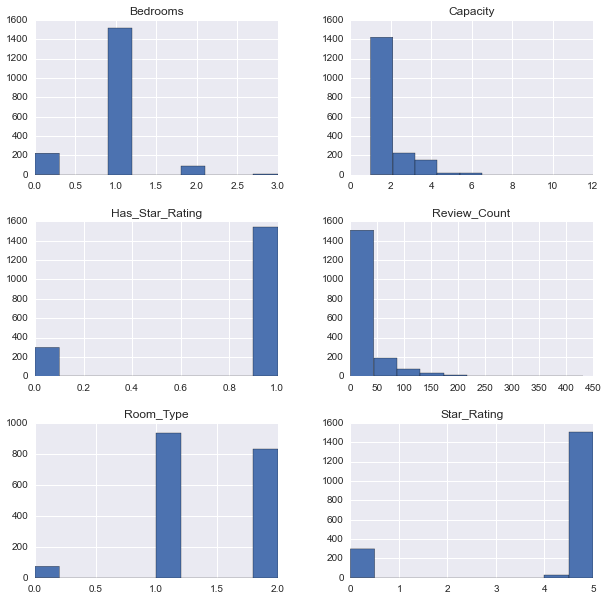

In [21]:
df_all[feat_cols].hist(figsize=(10,10))

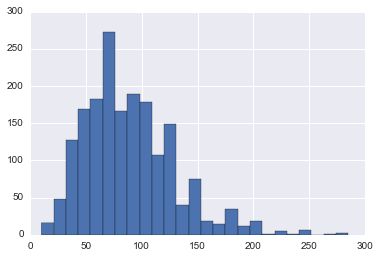

In [26]:
df_all.Price.hist(bins=25)

In [24]:
# How Star Rating values correspond to Price
sr_groupby = df_all.groupby('Star_Rating').Price.mean()
sr_groupby

Star_Rating
0.0    88.835570
2.5    65.000000
3.5    36.666667
4.0    76.880000
4.5    82.779221
5.0    90.818344
Name: Price, dtype: float64

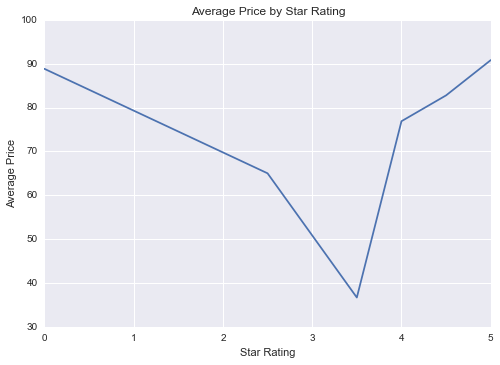

In [30]:
plt.plot(sr_groupby.index, sr_groupby.values)
plt.title('Average Price by Star Rating')
plt.xlabel('Star Rating')
plt.ylabel('Average Price')

### Let's look at a scatter matrix

In [27]:
sm_cols = ['Bedrooms','Capacity','Has_Star_Rating','Review_Count','Room_Type','Star_Rating','Price']

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x10d081150>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x10e767610>]], dtype=object)

/Users/paulsingman/pyth/data-analysis/venv/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


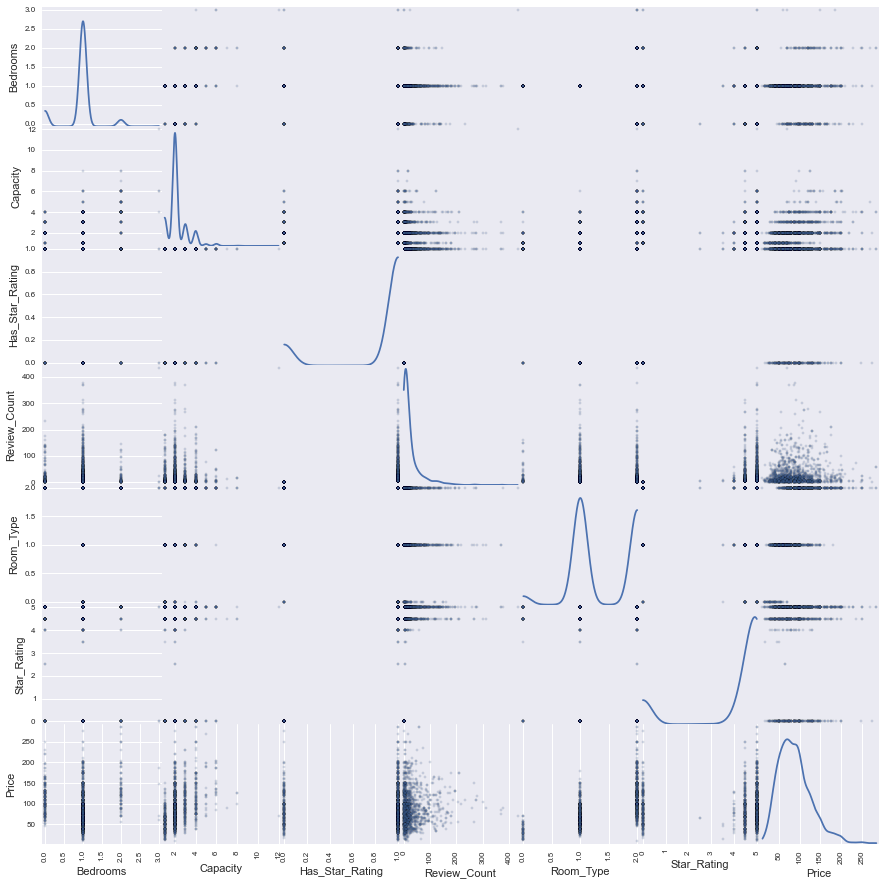

In [28]:
pd.tools.plotting.scatter_matrix(df_all[sm_cols], alpha=0.2, figsize=(15, 15), diagonal='kde')

### Correlation matrix

In [29]:
df_all[sm_cols].corr()

,Bedrooms,Capacity,Has_Star_Rating,Review_Count,Room_Type,Star_Rating,Price
Bedrooms,1.000000,0.317923,-0.054905,0.014055,-0.162514,-0.045642,-0.010372
Capacity,0.317923,1.000000,-0.015300,0.049147,0.443049,-0.007313,0.396855
Has_Star_Rating,-0.054905,-0.015300,1.000000,0.271267,-0.030215,0.991021,-0.003583
Review_Count,0.014055,0.049147,0.271267,1.000000,-0.035037,0.273466,0.040921
Room_Type,-0.162514,0.443049,-0.030215,-0.035037,1.000000,-0.027815,0.618045
Star_Rating,-0.045642,-0.007313,0.991021,0.273466,-0.027815,1.000000,0.009269
Price,-0.010372,0.396855,-0.003583,0.040921,0.618045,0.009269,1.000000


## Fit baseline model (predict the city's average price for every listing)

In [30]:
def fit_baseline(X, y):
    """Fit baseline prediction model where we predict a city's avg for each listing"""
    base_r2 = metrics.r2_score(y, X)
    base_RMSE = np.sqrt(metrics.mean_squared_error(y, X))
    
    return (base_r2, base_RMSE)

In [31]:
base_r2, base_RMSE = fit_baseline(df_all.Avg_Price, df_all.Price)
print "Baseline model R-squared: {:.3f}".format(base_r2)
print "Baseline model RMSE: {:.3f}".format(base_RMSE)

Baseline model R-squared: 0.110
Baseline model RMSE: 38.382


## Now let's improve upon it

In [53]:
regression_features = ['Star_Rating','Has_Star_Rating','Bedrooms','Room_Type', 'Capacity','Review_Count',
                       'City_NY','City_SF','City_DA','City_DC','City_LA']
X = df_all[regression_features]
y = df_all.Price

# split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 123)

In [8]:
def train_model(clf, X_train, y_train):
    """Trains the classifier"""
    print "----------------------------"
    print "Training {}...".format(clf.__class__.__name__)
    start = time.time()
    clf.fit(X_train, y_train)
    end = time.time()
    print "Done!\nTraining time (secs): {:.3f}".format(end - start)
    
    return clf

In [9]:
def model_predictions(clf, X_train, X_test):
    """Generate predictions from the training and testing data"""
    train_predictions = clf.predict(X_train)
    test_predictions = clf.predict(X_test)
    
    return (train_predictions, test_predictions)

In [10]:
def score_model(train_preds, test_preds, train_truth, test_truth):
    """Return the R-squared on the test data, and the RMSE on the train and test data"""
    train_RMSE = np.sqrt(metrics.mean_squared_error(train_truth, train_preds))
    test_RMSE = np.sqrt(metrics.mean_squared_error(test_truth, test_preds))
    
    test_rsquare = metrics.r2_score(test_truth, test_preds)
    
    return (train_RMSE, test_RMSE, test_rsquare)

In [11]:
def regression_model(clf, X_train, X_test, y_train, y_test):
    """This function:
     - trains the model on the training
     - makes predictions on the test set
     - reports the r_squared and RMSE of the model
    """
    clf = train_model(clf, X_train, y_train)
    train_predictions, test_predictions = model_predictions(clf, X_train, X_test)
    train_RMSE, test_RMSE, test_rsquare = score_model(train_predictions, test_predictions, y_train, y_test)
    
    print "RMSE for training set: {}".format(train_RMSE)
    print "RMSE score for test set: {}".format(test_RMSE)
    print "R-Squared for test set: {}".format(test_rsquare)
    
    return clf 

In [45]:
lr_ridge = Ridge()
lr_ols = LinearRegression()
lr_lasso = Lasso()
lr_elasticnet = ElasticNet()

In [46]:
lr_ridge = regression_model(lr_ridge, X_train, X_test, y_train, y_test)

----------------------------
Training Ridge...
Done!
Training time (secs): 0.002
RMSE for training set: 27.3472326159
RMSE score for test set: 28.3380972765
R-Squared for test set: 0.523198045545


In [47]:
zip(regression_features,lr_ridge.coef_)

[('Star_Rating', 12.547501485695092),
 ('Has_Star_Rating', -58.977051252187401),
 ('Bedrooms', 6.0421309107066437),
 ('Room_Type', 41.904349446596889),
 ('Capacity', 6.5565798893502318),
 ('Review_Count', 0.018048773124688791),
 ('City_NY', 23.042739832376778),
 ('City_SF', 41.296565422567873),
 ('City_DA', -1.3746104117652609),
 ('City_DC', 9.681606200537713),
 ('City_LA', 5.855606217889906)]

In [48]:
lr_ols = regression_model(lr_ols, X_train, X_test, y_train, y_test)

----------------------------
Training LinearRegression...
Done!
Training time (secs): 0.001
RMSE for training set: 27.3323151303
RMSE score for test set: 28.3666468061
R-Squared for test set: 0.522236842795


In [49]:
zip(regression_features,lr_ols.coef_)

[('Star_Rating', 16.056704526921926),
 ('Has_Star_Rating', -76.315454996179469),
 ('Bedrooms', 6.0599749758001771),
 ('Room_Type', 42.038107280801057),
 ('Capacity', 6.4830462177985648),
 ('Review_Count', 0.017642205284154253),
 ('City_NY', 23.711064607628618),
 ('City_SF', 41.959658231774483),
 ('City_DA', -0.99613231958113058),
 ('City_DC', 10.306896119594052),
 ('City_LA', 6.3757633392591391)]

In [50]:
lr_elasticnet = regression_model(lr_elasticnet, X_train, X_test, y_train, y_test)

----------------------------
Training ElasticNet...
Done!
Training time (secs): 0.002
RMSE for training set: 33.3207798611
RMSE score for test set: 33.2261363697
R-Squared for test set: 0.34452468668


In [51]:
zip(regression_features,lr_elasticnet.coef_)

[('Star_Rating', 0.16177470516691062),
 ('Has_Star_Rating', -0.0),
 ('Bedrooms', -0.19637869526813961),
 ('Room_Type', 14.350698701672822),
 ('Capacity', 7.9614581956529422),
 ('Review_Count', 0.03341037540532487),
 ('City_NY', 1.3335063406603054),
 ('City_SF', 6.3908178228677519),
 ('City_DA', -1.933955571549564),
 ('City_DC', 0.0),
 ('City_LA', -1.4957997134749459)]

In [52]:
lr_lasso = regression_model(lr_lasso, X_train, X_test, y_train, y_test)

----------------------------
Training Lasso...
Done!
Training time (secs): 0.002
RMSE for training set: 28.3009203644
RMSE score for test set: 28.9302308841
R-Squared for test set: 0.503064008226


In [53]:
zip(regression_features,lr_lasso.coef_)

[('Star_Rating', 0.20062294810488579),
 ('Has_Star_Rating', 0.0),
 ('Bedrooms', 0.0),
 ('Room_Type', 37.821289581862267),
 ('Capacity', 6.530503400235065),
 ('Review_Count', 0.030126438333514256),
 ('City_NY', 9.1156881773149259),
 ('City_SF', 28.131846123364777),
 ('City_DA', -0.68969066926517486),
 ('City_DC', 0.0),
 ('City_LA', -0.0)]

### Looks like all have similar performance except for elasticnet, we'll look into how we can optimize its performance. We'll optimize the alpha and l1_ratio parameters.

In [28]:
l1_ratios = [.05,.1, .5, .7, .9, .95, .99, 1]
alphas = [10e-4, 10e-3, 10e-2, 10e-1, 0, 1, 10, 100, 1000]

In [31]:
for r in l1_ratios:
    for a in alphas:
        lr_elasticnet = ElasticNet(alpha=a, l1_ratio=r)
        print "l1 ratio: {}, alpha: {}".format(r, a)
        lr_elasticnet = regression_model(lr_elasticnet, X_train, X_test, y_train, y_test)
        print"\n"
        

l1 ratio: 0.05, alpha: 0.001
----------------------------
Training ElasticNet...
Done!
Training time (secs): 0.016
RMSE for training set: 27.3547836693
RMSE score for test set: 28.3337115379
R-Squared for test set: 0.523345618397


l1 ratio: 0.05, alpha: 0.01
----------------------------
Training ElasticNet...
Done!
Training time (secs): 0.004
RMSE for training set: 27.5727452242
RMSE score for test set: 28.3202271773
R-Squared for test set: 0.523799201765


l1 ratio: 0.05, alpha: 0.1
----------------------------
Training ElasticNet...
Done!
Training time (secs): 0.001
RMSE for training set: 28.9860728618
RMSE score for test set: 29.0989022678
R-Squared for test set: 0.497252563065


l1 ratio: 0.05, alpha: 1.0
----------------------------
Training ElasticNet...
Done!
Training time (secs): 0.001
RMSE for training set: 34.9202007763
RMSE score for test set: 34.9340709129
R-Squared for test set: 0.275405474697


l1 ratio: 0.05, alpha: 0
----------------------------
Training ElasticNet...


/Users/paulsingman/pyth/data-analysis/venv/lib/python2.7/site-packages/ipykernel/__main__.py:6: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator


### Best elasticnet model has l1 ratio .1 and alpha .01, let's initialize that like with the other models

In [54]:
lr_elasticnet = ElasticNet(alpha=0.01, l1_ratio=0.1)

In [55]:
lr_elasticnet = regression_model(lr_elasticnet, X_train, X_test, y_train, y_test)

----------------------------
Training ElasticNet...
Done!
Training time (secs): 0.005
RMSE for training set: 27.5639573115
RMSE score for test set: 28.319962361
R-Squared for test set: 0.523808107426


In [56]:
zip(regression_features,lr_elasticnet.coef_)

[('Star_Rating', 3.8530966286643555),
 ('Has_Star_Rating', -15.997935290014611),
 ('Bedrooms', 5.093191809119257),
 ('Room_Type', 40.415624426534364),
 ('Capacity', 7.0028781830176055),
 ('Review_Count', 0.019703645053542104),
 ('City_NY', 18.618463764955894),
 ('City_SF', 36.272500323206366),
 ('City_DA', -4.058969584112937),
 ('City_DC', 6.0153769168714257),
 ('City_LA', 2.377869765043374)]

### Let's take a look at the plot of predictions vs actual

In [57]:
predictions = lr_elasticnet.predict(X_test)

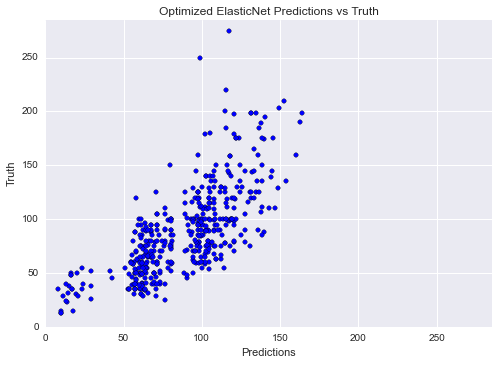

In [71]:
plt.scatter(predictions, y_test)
plt.xlim(0,285)
plt.ylim(0,285)
plt.title('Optimized ElasticNet Predictions vs Truth')
plt.xlabel('Predictions')
plt.ylabel('Truth')

### Let's take a look at residuals

In [79]:
residual_df = pd.DataFrame(data={'predictions':predictions,'y_test':y_test})

In [83]:
sorted_residual_df = residual_df.sort('y_test', axis=0)

In [86]:
sorted_residual_df['residuals'] = sorted_residual_df.predictions - sorted_residual_df.y_test

(-5, 300)

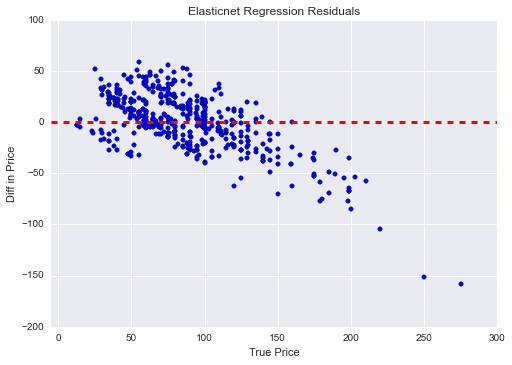

In [89]:
residuals = y_test - predictions
plt.scatter(sorted_residual_df.y_test,sorted_residual_df.residuals)
plt.axhline(ls='--', linewidth=3, color='r')
plt.title('Elasticnet Regression Residuals')
plt.xlabel('True Price')
plt.ylabel('Diff in Price')
plt.xlim(-5,300)

### The residuals show the mode is underpredicting high priced properties

In [ ]:
high_price_mask = df_all.Price>240
high_price_df = df_all[high_price_mask]

In [60]:
high_price_df.head()

,Bedrooms,Capacity,Price,Review_Count,Room_Type,Star_Rating,Avg_Price,Has_Star_Rating,City_DA,City_DC,City_LA,City_NY,City_SF
3,1,4,250,9,2,4.5,92.918301,1,0,0,0,1,0
13,1,2,275,1,2,0.0,92.918301,0,0,0,0,1,0
3,0,2,250,7,2,5.0,77.042484,1,0,0,1,0,0
11,2,4,285,56,2,5.0,114.284314,1,0,0,0,0,1
11,1,2,250,3,2,4.5,114.284314,1,0,0,0,0,1


### Understandable why we are underpredicting these higher Price properties, there's nothing in my features to capture them.

### Let's make a layman's metric (also for my curiosity) do percent of predictions within 20 dollars.

In [69]:
good = 0
for p, y in zip(predictions, y_test):
    if np.abs(p - y) < 20:
        good += 1

In [70]:
from __future__ import division
within20 = float(good/len(y_test))
within20

0.5446623093681917

### Not amazing, but 54% of listing predictions are within 20 dollars